In [1]:
from .preprocess_data import Custom_Dataset, ChannelMNISTDataset
from torch.utils.data import DataLoader
import torch
from model import BaseConvModel, ProtoModel, FinalLayer, WholeModel, exp_var_dict
from push_prototypes import push
import h5py
from receptive_field import compute_rf, output_to_input
import matplotlib.pyplot as plt
import numpy as np
import argparse
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim.lr_scheduler as lr_scheduler
from torchgeo_euro import EuroSAT, ScaleAndNormalize
from torchvision.transforms import v2 as transforms
import matplotlib
import pickle
import seaborn as sns
sns.set_theme()

ModuleNotFoundError: No module named 'channel_prototype_project'

In [ ]:
if torch.cuda.is_available():
    torch.set_default_device('cuda')
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda')
    print("GPU is set as the default device.")
else:
    print("CUDA is not available. CPU will be used as the default device.")
    device = 'cpu'

prototype_info = 'data/models/mjo_models/mjo_prototype_info'
model_name = 'data/models/mjo_models/mjo_model.pth'


GPU is set as the default device.


/users/anaray34/.local/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
exp_dataset = exp_var_dict['exp_dataset']
whole = WholeModel(exp_dataset, exp_var_dict['num_channels'])

with open(prototype_info, "rb") as fp:   
    prototype_info_list = pickle.load(fp)

whole.load_state_dict(torch.load(model_name))


<All keys matched successfully>

In [4]:
input_size = (32, 1, 16, 131)
chan_rf = []

for chan in range(exp_var_dict['num_channels']):
    imin_chan, imax_chan, jmin_chan, jmax_chan = compute_rf(whole.base_list[0], whole.proto_list[chan],input_size, prototype_info_list[chan][-1])
    chan_rf.append([imin_chan, imax_chan, jmin_chan, jmax_chan])

GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.


In [ ]:

lead_time = 0
file_name = "data/processed_mjo_data/processed_mjo.hdf5"

test_data = Custom_Dataset(hdf5_data_file=file_name, im_name='test_images',label_name='test_labels', exp_dataset=exp_dataset)

with h5py.File(file_name,'r') as f:
    all_images = f['train_images'][:]
    all_labels = f['train_labels'][:]
    all_times = f['train_time'][:]
    test_images = f['test_images'][:]

test_dataloader = DataLoader(test_data, shuffle=False)


Input Shape: torch.Size([1095, 3, 16, 131])


Testing accuracy: 0.5534246575342465
+1 Testing accuracy: 0.8045662100456621


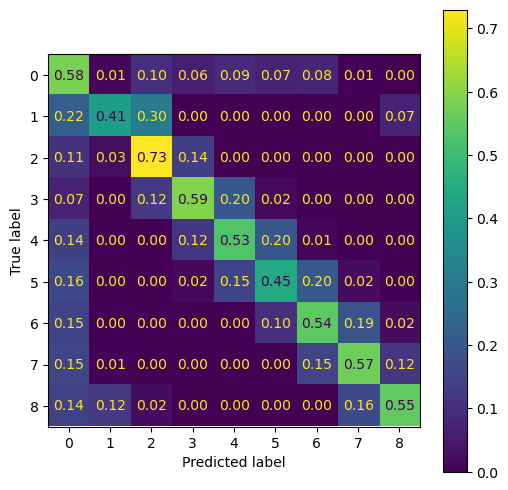

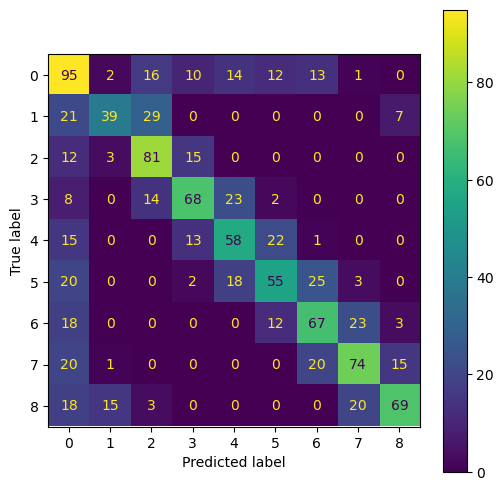

In [6]:
sns.reset_defaults()
plt.style.use('default')
plt.rcdefaults()
epoch_cross_entropy = 0
n_examples = 0
n_correct = 0
n_correct_1 = 0

tp_active = 0
tn_inactive = 0
fp_inact_act = 0
fn_act_inact = 0

correct = []
true_label = []
pred_label = []
index_nums = []
index_num = 0

max_inds_arr_list = []
max_sims_arr_list = []
for inputs, labels in test_dataloader:
    inputs = torch.nan_to_num(inputs)
    whole.base_list[0].eval()
    for chan in range(exp_var_dict['num_channels']):
        
        whole.proto_list[chan].eval()
    whole.final_list[0].eval()
    with torch.no_grad():
        output, min_dist_list, scaled_sim_list = whole(inputs, False)

        # compute loss
        cross_entropy = torch.nn.functional.cross_entropy(output, labels.to(torch.long))

        predicted = torch.max(output.data, 1)
        n_examples += labels.size(0)
        n_correct += torch.eq(predicted[1], labels).sum().item()
        n_correct_1 += (abs(predicted[1]-labels) < 2).sum().item()

        if predicted[1] == 0 and labels != 0:
            fn_act_inact +=1
        if predicted[1] == 0 and labels == 0:
            tn_inactive +=1
        if predicted[1] != 0 and labels != 0:
            tp_active += 1
        if predicted[1] !=0 and labels == 0:
            fp_inact_act +=1

        correct.append(torch.eq(predicted[1], labels).sum().item())
        true_label.append(int(labels.cpu().item()))
        pred_label.append(predicted[1].cpu().item())
        index_nums.append(index_num)
        index_num+=1

    max_inds_chan = []
    max_sims_chan = []
    for chan in range(exp_var_dict['num_channels']):
        indices = [np.unravel_index(np.argmax(r.cpu()), r.cpu().shape) for r in scaled_sim_list[chan][0]]
        max_inds_chan.append(indices[:])

        sim_values = [torch.amax(scaled_sim_list[chan], dim=(2,3)).cpu().detach().numpy()]
        max_sims_chan.append(sim_values[0][0][:])
    max_inds_arr_list.append(max_inds_chan)
    max_sims_arr_list.append(max_sims_chan)

acc = n_correct/n_examples
print('Testing accuracy: ' + str(acc))
print('+1 Testing accuracy: ' + str(n_correct_1/n_examples))

cm = confusion_matrix(np.asarray(true_label), np.asarray(pred_label), normalize='true')
fig, ax = plt.subplots(figsize=(6,6))
ax = plt.gca()
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax=ax,values_format='.2f')

fig.canvas.draw()  

cm = confusion_matrix(np.asarray(true_label), np.asarray(pred_label))
fig, ax = plt.subplots(figsize=(6,6))
ax = plt.gca()
disp = ConfusionMatrixDisplay(np.round(cm,2))
disp.plot(ax=ax)

fig.canvas.draw()  

lats = np.linspace(-15, 15, 16) 
lons = np.arange(0,262, 2)

all_loc_scale = []
all_conv_prototypes = []
all_prototype_sample_ind = []

for chan in range(exp_var_dict['num_channels']):
    all_loc_scale.append(prototype_info_list[chan][5].cpu().detach().numpy())
    all_conv_prototypes.append(prototype_info_list[chan][4])
    all_prototype_sample_ind.append(prototype_info_list[chan][0])
all_max_inds = np.asarray(max_inds_arr_list) 
all_max_sims = np.asarray(max_sims_arr_list) 



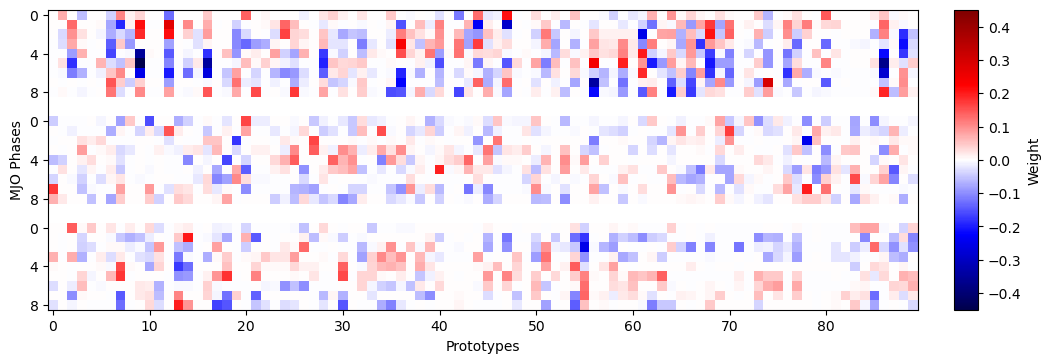

In [7]:

weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()  

data = weights
num_channels = 3
gap = 2  
blocks = np.hsplit(data, num_channels)

spaced_blocks = []
for i, b in enumerate(blocks):
    spaced_blocks.append(b)
    if i < num_channels - 1:
        spaced_blocks.append(np.full((gap, b.shape[1]), np.nan))

stacked_data = np.vstack(spaced_blocks)

norm = matplotlib.colors.TwoSlopeNorm(vmin=-0.45, vcenter=0, vmax=0.45)

cmap = plt.get_cmap("seismic").copy()
cmap.set_bad(color="white")

fig, ax = plt.subplots(figsize=(12, 24))
fig.subplots_adjust(right=0.85)

im = ax.imshow(stacked_data, cmap=cmap, aspect="equal", norm=norm)
ax_pos = ax.get_position()
cax = fig.add_axes([
    ax_pos.x1 + 0.03,  
    ax_pos.y0,        
    0.02,            
    ax_pos.height 
])

cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Weight")

ticks = []
labels = []
rows_per_block = blocks[0].shape[0]
offset = 0
for _ in range(num_channels):
    ticks.extend([offset + 0, offset + 4, offset + 8])
    labels.extend([0, 4, 8])
    offset += rows_per_block + gap

ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax.set_xlabel("Prototypes")
ax.set_ylabel("MJO Phases")

#plt.savefig('mjo_figs/mjo_weights_noise2.pdf', format='pdf', bbox_inches='tight')

plt.show()


In [14]:
def plot_prototype(ind, chan_rf, input_size, all_conv_prototypes, all_prototype_sample_ind, all_images, all_loc_scale, lats, lons, show=False, return_axes=False, q=0):
    fig, axs = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, figsize=(6,6))
    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']

    i = int(all_conv_prototypes[chan_num][all_num,0])
    j = int(all_conv_prototypes[chan_num][all_num,1])

    proto_ind = int(all_prototype_sample_ind[chan_num][all_num]) 
    axs.set_xlim(0, 260)
    axs.set_ylim(-15, 15)

    if chan_num == 0:
        levels = np.arange(-6, 6, 1)
    elif chan_num == 1:
        levels = np.arange(-6, 6, 1)
    else:
        levels = np.arange(-6, 6, 1)
    norm = matplotlib.colors.TwoSlopeNorm(vcenter=0)

    contour = axs.contourf(lons, lats, all_images[proto_ind,:,:,chan_num],levels=levels, cmap='RdBu_r', norm=norm)
    axs.coastlines()
    #axs.imshow(all_images[proto_ind,chan_num,:,:])
    
    input_mask, y1, y2, x1, x2 = output_to_input(i,j,chan_rf[chan_num][0], chan_rf[chan_num][1], chan_rf[chan_num][2], chan_rf[chan_num][3], input_size)

    lon1, lon2 = lons[x1], lons[x2 - 1]
    lat1, lat2 = lats[y1], lats[y2 - 1]

    lower_left_lon = min(lon1, lon2)
    lower_left_lat = min(lat1, lat2)
    width = abs(lon2 - lon1) + (lons[1] - lons[0])  
    height = abs(lat2 - lat1) + (lats[1] - lats[0]) 

    rect = patches.Rectangle((lower_left_lon, lower_left_lat),
                            width/2, height,
                            linewidth=2,
                            edgecolor='red',
                            facecolor='none',
                            transform=ccrs.PlateCarree())
    axs.add_patch(rect)
    axs.set_xticks([])
    axs.set_yticks([])
    #plt.savefig('mjo_figs/mjo_'+str(q)+'_winning.pdf', format='pdf', bbox_inches='tight')
    
    
    if show == True:
        plt.show()
    
    plt.imshow(np.flip(all_loc_scale[chan_num][all_num],axis=0),vmin=-1, vmax=1,cmap='RdGy')
    
    loc_axis = plt.gca()
    loc_axis.set_xticks([])
    loc_axis.set_yticks([])
    #plt.savefig('mjo_figs/mjo_'+str(q)+'_secondwinning_loc.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    

    if return_axes == True:
        return axs, loc_axis
    

True Label: 3
Winning Prototype Label: 3.0
Winning Prototype Day: b'2014-03-30T00:00:00.000000000Z'
Winning Prototype Number: 36
Winning Prototype Score: 2.2133214
Winning Prototype Channel: 0


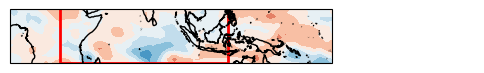

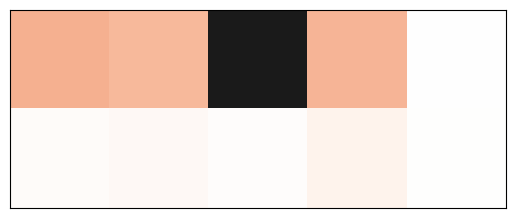

Test Sample: 12
Channel: 0


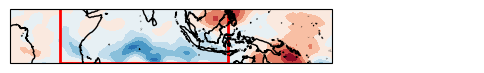

True Label: 1
Winning Prototype Label: 1.0
Winning Prototype Day: b'2002-08-28T00:00:00.000000000Z'
Winning Prototype Number: 12
Winning Prototype Score: 2.7474835
Winning Prototype Channel: 0


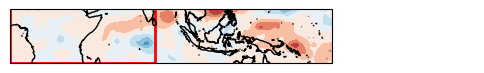

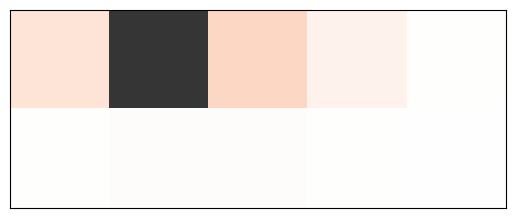

Test Sample: 14
Channel: 0


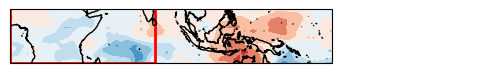

True Label: 0
Winning Prototype Label: 0.0
Winning Prototype Day: b'2000-01-10T00:00:00.000000000Z'
Winning Prototype Number: 182
Winning Prototype Score: 1.2141907
Winning Prototype Channel: 2


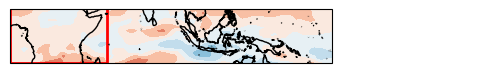

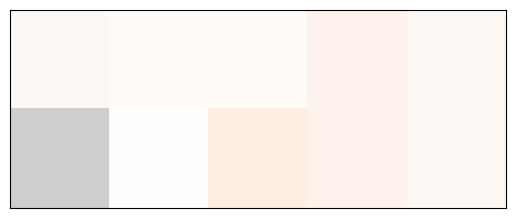

Test Sample: 24
Channel: 2


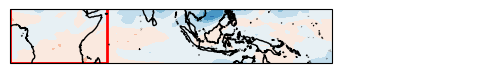

True Label: 8
Winning Prototype Label: 8.0
Winning Prototype Day: b'2006-10-11T00:00:00.000000000Z'
Winning Prototype Number: 86
Winning Prototype Score: 3.733952
Winning Prototype Channel: 0


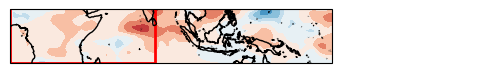

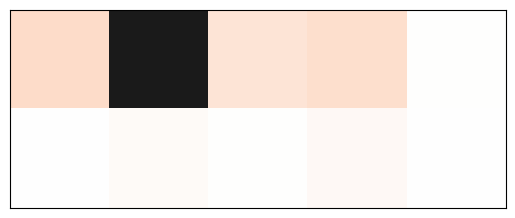

Test Sample: 33
Channel: 0


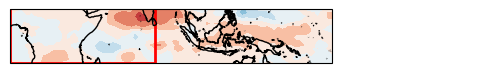

True Label: 5
Winning Prototype Label: 5.0
Winning Prototype Day: b'1986-04-03T00:00:00.000000000Z'
Winning Prototype Number: 235
Winning Prototype Score: 1.1512381
Winning Prototype Channel: 2


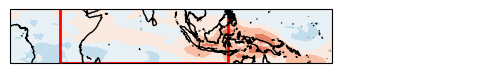

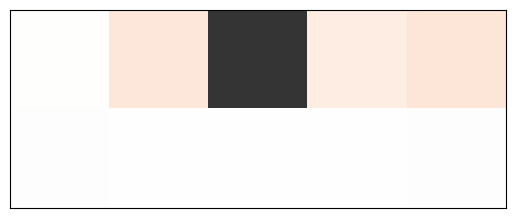

Test Sample: 54
Channel: 2


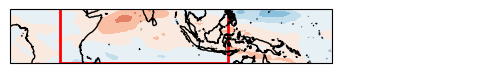

True Label: 6
Winning Prototype Label: 6.0
Winning Prototype Day: b'1985-09-11T00:00:00.000000000Z'
Winning Prototype Number: 61
Winning Prototype Score: 1.9183016
Winning Prototype Channel: 0


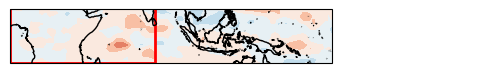

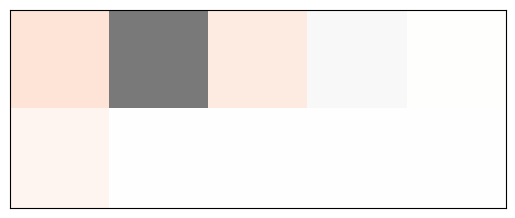

Test Sample: 719
Channel: 0


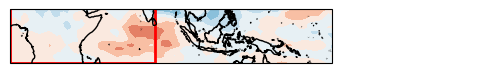

In [ ]:

sns.reset_defaults()
plt.style.use('default')
plt.rcdefaults()
for q in [12, 14, 24, 33, 54, 64, 719]:

    pred_lab = pred_label[q]
    weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
    sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
    scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

    scores_sort = np.argsort(scores)
    ind = scores_sort[-1]
    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']

    proto_ind = int(all_prototype_sample_ind[chan_num][all_num])

    i3 = int(all_conv_prototypes[chan_num][all_num,0])
    j3 = int(all_conv_prototypes[chan_num][all_num,1])

    if int(all_labels[proto_ind]) == int(true_label[q]):
        print('True Label: '+str(true_label[q]))
        print('Winning Prototype Label: '+str(all_labels[proto_ind]))
        print('Winning Prototype Day: '+str(all_times[proto_ind]))
        print('Winning Prototype Number: '+str(ind)) 
        print('Winning Prototype Score: '+str(scores[ind]))
        print('Winning Prototype Channel: '+str(chan_num))


        #Plot highest scpring prototype
        plot_prototype(ind, chan_rf, input_size, all_conv_prototypes, all_prototype_sample_ind, all_images, all_loc_scale, lats, lons, show=True, q=q)

        #Uncomment to plot second highest scoring prototype
        """
        ind2 = scores_sort[-2]
        chan_num2 = ind2 // exp_var_dict['num_prototypes']
        all_num2 = ind2 % exp_var_dict['num_prototypes']
        proto_ind2 = int(all_prototype_sample_ind[chan_num2][all_num2])
        
        
        print('Second Winning Prototype Label: '+str(all_labels[proto_ind2]))
        print('Second Winning Prototype Day: '+str(all_times[proto_ind2]))
        print('Second Winning Prototype Number: '+str(ind2)) # out of 240
        print('Second Winning Prototype Score: '+str(scores[ind2]))
        print('Second Winning Prototype Channel: '+str(chan_num2))
        plot_prototype(ind, chan_rf, input_size, all_conv_prototypes, all_prototype_sample_ind, all_images, all_loc_scale, lats, lons, show=True, q=q)
        """
        
        fig, axs = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)},figsize=(6,9))
        
        axs.set_xlim(0, 260)
        axs.set_ylim(-15, 15)
        if chan_num == 0:
            levels = np.arange(-6, 6, 1)
        elif chan_num == 1:
            levels = np.arange(-6, 6, 1)
        else:
            levels = np.arange(-6, 6, 1)
        norm = matplotlib.colors.TwoSlopeNorm(vcenter=0)
        print('Test Sample: '+str(q))
        print('Channel: '+str(chan_num))

        #Plot test sample
        contour = axs.contourf(lons, lats, test_images[q,:,:,chan_num],levels=levels, cmap='RdBu_r', norm=norm)
        axs.coastlines()   

        sim_values = all_max_sims[q,chan_num,:] 
        scores = sim_values * weights[pred_lab,chan_num*exp_var_dict['num_prototypes']:(chan_num+1)*exp_var_dict['num_prototypes']]
        scores_sort = np.argsort(scores)
        ind = scores_sort[-1]

        i = all_max_inds[q][chan_num][ind][0]
        j = all_max_inds[q][chan_num][ind][1]
        input_mask, y1, y2, x1, x2 = output_to_input(i,j,chan_rf[chan_num][0], chan_rf[chan_num][1], chan_rf[chan_num][2], chan_rf[chan_num][3], input_size)

        lon1, lon2 = lons[x1], lons[x2 - 1]
        lat1, lat2 = lats[y1], lats[y2 - 1]
        lower_left_lon = min(lon1, lon2)
        lower_left_lat = min(lat1, lat2)
        width = abs(lon2 - lon1) + (lons[1] - lons[0])  
        height = abs(lat2 - lat1) + (lats[1] - lats[0]) 
        rect = patches.Rectangle((lower_left_lon, lower_left_lat),
                                width/2, height,
                                linewidth=2,
                                edgecolor='red',
                                facecolor='none',
                                transform=ccrs.PlateCarree())
        axs.add_patch(rect)
        #plt.savefig('mjo_figs/mjo_'+str(q)+'_'+str(chan)+'_label'+str(pred_lab)+'.pdf', format='pdf', bbox_inches='tight')
        plt.show()




In [10]:
month_arr = np.zeros((exp_var_dict['num_channels'],12))
for ind in range(0,exp_var_dict['num_prototypes']*exp_var_dict['num_channels']):
    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']
    if all_num >9:
        proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
        month_arr[chan_num, int(all_times[proto_ind][5:7])-1]+=1


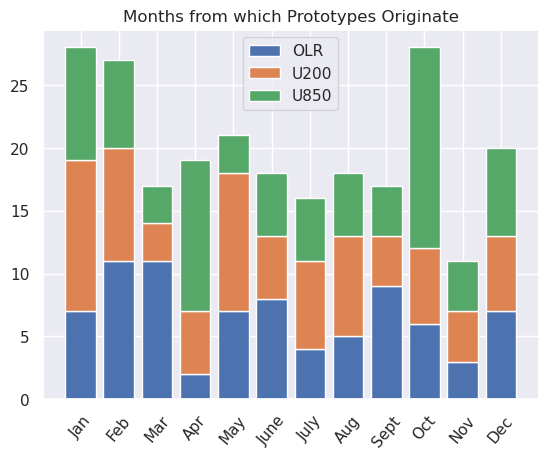

In [11]:

sns.set_theme()
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.bar(x,month_arr[0], label='OLR')
plt.bar(x,month_arr[1], bottom = month_arr[0], label='U200')
plt.bar(x,month_arr[2], bottom = month_arr[0] + month_arr[1], label='U850')
plt.xticks(rotation=50)
plt.legend()
plt.title('Months from which Prototypes Originate')

plt.show()